# Using custom labelling schemes

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lucasmiranda42/deepof/blob/master/docs/source/tutorial_notebooks/deepof_custom_labels_tutorial.ipynb)

##### What we'll cover:
    
* Labelling schemes supported by DeepOF.
* How to create a new labelling scheme and integrate it with the unsupervised pipeline.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# # If using Google colab, uncomment and run this cell and the one below to set up the environment
# # Note: because of how colab handles the installation of local packages, this cell will kill your runtime.
# # This is not an error! Just continue with the cells below.
# import os
# !git clone -q https://github.com/mlfpm/deepof.git
# !pip install -q -e deepof --progress-bar off
# os.chdir("deepof")
# !curl --output tutorial_files.zip https://datashare.mpcdf.mpg.de/s/QoawozFfT53JfPW/download
# !unzip tutorial_files.zip
# os.kill(os.getpid(), 9)

In [3]:
# os.chdir("deepof")
# import os, warnings
# warnings.filterwarnings('ignore')

Let's start by importing some packages. We'll use python's os library to handle paths, pickle to load saved objects, pandas to load data frames, and the data entry API within DeepOF, located in deepof.data

In [4]:
import os
import pandas as pd
import pickle
import deepof.data

We'll also need some plotting gear:

In [5]:
from IPython import display
from networkx import Graph, draw
import deepof.visuals
import matplotlib.pyplot as plt
import seaborn as sns

### Recap: labelling schemes supported by DeepOF

DeepOF supports two labelling schemes out of the box: the `deepof_14` scheme, selected by default, and `deepof_8`, a reduced set of tracking labels that is common among, for example, [SimBA](https://goldenneurolab.com/simba) users.

**NOTE**: This is not necessary if you use the matrix representations introduced in the previous tutorial. If you'd like to try out the graph representations we explored, however, but you have a different labelling scheme, this is the place to be.

<img src="./Assets/deepof_DLC_tagging.png"  width="800">

While, as mentioned above, `deepof_14` is selected by default, the provided alternative can be selected when defining a new `deepof.Project` instance:

In [6]:
my_deepof_project = deepof.data.Project(
    project_path=os.path.join("tutorial_files"),
    video_path=os.path.join("tutorial_files/Videos/"),
    table_path=os.path.join("tutorial_files/Tables/"),
    project_name="deepof_tutorial_project",
    arena="circular-autodetect",
    animal_ids=["B", "W"],
    video_format=".mp4",
    bodypart_graph="deepof_8",  # Can also be set to 'deepof_14' (default), 'deepof_11' or take a custom graph
    video_scale=380,
    iterative_imputation="partial",
    smooth_alpha=1,
    exp_conditions=None,
)

In [7]:
my_deepof_project = my_deepof_project.create(force=True)

Setting up project directories...


Computing areas     : 100%|██████████| 6/6 [00:00<00:00,  6.86table/s]


Done!


We can take a look at the constructed graph in this case (you can see how the default looks like in the previous tutorial, or change the labelling scheme to `deepof_14` in the cell above if you're following in colab):

In [8]:
graph_preprocessed_coords, shapes, adj_matrix, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
    animal_id="B", # Comment out for multi-animal embeddings
    center="Center",
    align="Spine_1",
    window_size=25,
    window_step=1,
    test_videos=1,
    preprocess=True,
    scale="standard",
)

Reshaping     : 100%|██████████| 2/2 [00:00<00:00,  2.35table/s]


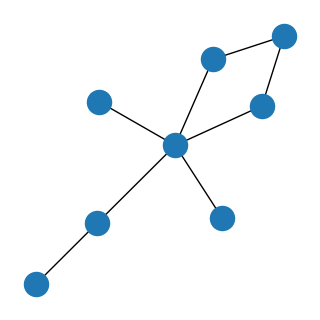

In [9]:
plt.figure(figsize=(3, 3))
draw(Graph(adj_matrix))
plt.show()

We indeed see a graph with 8 labels! The diamond shape corresponds to nose, ears and center. The outer branches to both sides and the tail.

This will adapt the whole downstream pipeline to work with the 8-label scheme. A more flexible alternative, if neither scheme fits your data, is to create a custom graph. Next, let's see how this can be achieved!

### Creating a new labelling scheme

Now, on for a slightly more involved task. What happens if we want another labelling scheme, not supported by DeepOF? We need to build the graph by hand using an adjacency list, and pass it to the `deepof.Project` constructor. Let's see! We'll adapt the `deepof_8` labelling scheme to include the full tail, which should look like this:

<img src="./Assets/deepof_custom_tagging.png"  width="400">

To start, we should create a Python dictionary specifying all connections we want. To be clear, keys in the dictionary will be connected to every element in the lists passed as values. There is no unique way of implementing this, so feel free to be creative! But an example that works is the following:

In [10]:
deepof_custom = {
    "Nose": ["Left_ear", "Right_ear"],
    "Center": ["Left_ear", "Right_ear", "Left_fhip", "Right_fhip", "Tail_base"],
    "Tail_base": ["Tail_1"],
    "Tail_1": ["Tail_2"],
    "Tail_2": ["Tail_tip"],
}

Here, `Nose` is connected to `Left_ear` and `Right_ear`, and so on. Next, we'll pass this structure to the `bodypart_graph` parameter in the `deepof.Project` constructor.

In [11]:
my_deepof_project = deepof.data.Project(
    project_path=os.path.join("tutorial_files"),
    video_path=os.path.join("tutorial_files/Videos/"),
    table_path=os.path.join("tutorial_files/Tables/"),
    project_name="deepof_tutorial_project",
    arena="circular-autodetect",
    animal_ids=["B", "W"],
    video_format=".mp4",
    bodypart_graph=deepof_custom,  # Can also be set to 'deepof_14' (default), 'deepof_11' or 'deepof_8'
    video_scale=380,
    iterative_imputation="partial",
    smooth_alpha=1,
    exp_conditions=None,
)

In [12]:
my_deepof_project = my_deepof_project.create(force=True)

Setting up project directories...


Computing areas     : 100%|██████████| 6/6 [00:00<00:00, 20.20table/s]


Done!


### Getting a custom graph dataset for the unsupervised pipeline

Now everything works the same way as before! Let's then obtain a new graph dataset using this custom labelling scheme, and make sure the obtained graph matches our expectations:

In [13]:
graph_preprocessed_coords, shapes, adj_matrix, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
    animal_id="B", # Comment out for multi-animal embeddings
    center="Center",
    align="Spine_1",
    window_size=25,
    window_step=1,
    test_videos=1,
    preprocess=True,
    scale="standard",
)

Reshaping     : 100%|██████████| 2/2 [00:01<00:00,  1.98table/s]


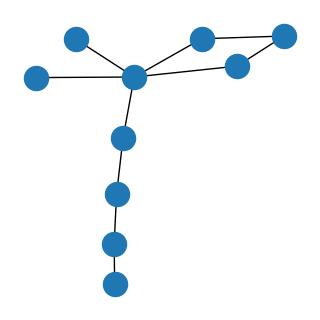

In [14]:
plt.figure(figsize=(3, 3))
draw(Graph(adj_matrix))
plt.show()

And that's it! Now you should be able to adapt the unsupervised pipeline within DeepOF to any labelling scheme of choice. Note that this should still work with bottom-up or side view videos.

### Wrapping up

Thank you for making it until the end. This was a slightly more involved tutorial for those users that do not rely on top-down labels like those provided out of the box. Stay tuned for more content, and make sure to raise an [issue](https://github.com/mlfpm/deepof/issues) in our GitHub repository if you have any questions!

# Working with large datasets in Deepof

(For the test version, this tutorial is currently only attached to the custom labels tutorial (to make them run with out automatized tests without having to restructure a ton of stuff). It will stand on its own later)

##### What we'll cover:
    
* How to process large datasets (several hours of recording per video) with deepof
* Things to consider when working with large quantities of data

We start with importing the usual packages

In [15]:
import copy
import os
import numpy as np
import pickle
import deepof.data

And plotting gear

In [16]:
from IPython import display
from networkx import Graph, draw
import deepof.visuals
import matplotlib.pyplot as plt
import seaborn as sns

### Brief introduction to large dataset analysis

In general, analysing very large datasets works, on a user level, almost the same as analyzing small datasets. The main difference is that
1. Things take longer
2. Tables do not stay loaded in the RAM, but instead get saved and loaded in the background as tehy are needed

The latter leads to the ubiquitous Table dictionaries in deepof now carrying only links to file locations instead of the tables themselves. 

For this tutorial we do not provide an additional "big" dataset (as we do not want you to wait several hours for a downlaod). Instead we are going to load the same sample_project as in the unsupervised tutorial. Then we simply manually set the "_very_large_project" project-variable to True, which will cause the project to behave just like it would if it had videos with multiple hours long of recordings. 

If you create your own project with a larger dataset (i.e. at least one video that is about 4 hours long or longer) this variable will simply be automatically set to True during project set up. 

In [17]:
# We load our small sample project, then we pretend that it is a big one
my_deepof_project = deepof.data.load_project("./tutorial_files/sample_project")
my_deepof_project.load_exp_conditions("./tutorial_files/tutorial_exp_conditions.csv")
my_deepof_project._very_large_project=True

Now let's create some supervised annotations

In [18]:
supervised_annotation = my_deepof_project.supervised_annotation()

supervised annotations: 100%|██████████| 6/6 [00:01<00:00,  3.18table/s, step=post processing]   


If we now try to have a look at one of our tables that we created we notice a difference: Instead of seeing the table, deepof now only displays the path to the file in which thsi table was stored.

In [19]:
supervised_annotation['20191204_Day2_SI_JB08_Test_54']

'./tutorial_files\\sample_project\\Tables\\20191204_Day2_SI_JB08_Test_54\\20191204_Day2_SI_JB08_Test_54_supervised_annotations.pqt'

If we want to load this table we can access it with the "get_dt" function and a syntax very similar to calling a dictionary entry

In [20]:
deepof.data_loading.get_dt(supervised_annotation,'20191204_Day2_SI_JB08_Test_54')

,B_W_nose2nose,B_W_sidebyside,B_W_sidereside,B_W_nose2tail,W_B_nose2tail,B_W_nose2body,W_B_nose2body,B_W_following,W_B_following,B_climbing,...,B_huddle,B_lookaround,B_speed,W_climbing,W_sniffing,W_huddle,W_lookaround,W_speed,B_missing,W_missing
00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.000,0.0,0.0,1.0,0.0,0.000,0,0
00:00:00.040002666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.000,0.0,0.0,1.0,0.0,0.000,0,0
00:00:00.080005333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.000,0.0,0.0,1.0,0.0,0.000,0,0
00:00:00.120008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0,0
00:00:00.160010667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.627,0.0,0.0,0.0,0.0,5.110,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:09:59.799986665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.593,0.0,0.0,1.0,1.0,0.086,0,0
00:09:59.839989332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.934,0.0,0.0,1.0,1.0,0.083,0,0
00:09:59.879991999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.557,0.0,0.0,1.0,1.0,0.064,0,0
00:09:59.919994666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.130,0.0,0.0,1.0,1.0,0.046,0,0


We also can retrieve only some meta information (like the column names, the number of rows and columns and such) as a dictionary by sligthly modifying our call

In [21]:
deepof.data_loading.get_dt(supervised_annotation,'20191204_Day2_SI_JB08_Test_54', only_metainfo=True, load_index=True)

{'index_column': Index(['00:00:00', '00:00:00.040002666', '00:00:00.080005333',
        '00:00:00.120008', '00:00:00.160010667', '00:00:00.200013334',
        '00:00:00.240016001', '00:00:00.280018667', '00:00:00.320021334',
        '00:00:00.360024001',
        ...
        '00:09:59.599973331', '00:09:59.639975998', '00:09:59.679978665',
        '00:09:59.719981332', '00:09:59.759983998', '00:09:59.799986665',
        '00:09:59.839989332', '00:09:59.879991999', '00:09:59.919994666',
        '00:09:59.959997333'],
       dtype='object', length=14999),
 'start_time': '00:00:00',
 'end_time': '00:09:59.959997333',
 'columns': ['B_W_nose2nose',
  'B_W_sidebyside',
  'B_W_sidereside',
  'B_W_nose2tail',
  'W_B_nose2tail',
  'B_W_nose2body',
  'W_B_nose2body',
  'B_W_following',
  'W_B_following',
  'B_climbing',
  'B_sniffing',
  'B_huddle',
  'B_lookaround',
  'B_speed',
  'W_climbing',
  'W_sniffing',
  'W_huddle',
  'W_lookaround',
  'W_speed',
  'B_missing',
  'W_missing'],
 'num_cols'

Plotting the data can be done in the same way as with small datasets. All plot functions have the optional input "samples_max" which denotes the maximum number of samples plotted and is set to 20000 for most plots as a default. So do not be afraid of excessive waiting times when plotting. Let's have a look at the Gant plot as an example:

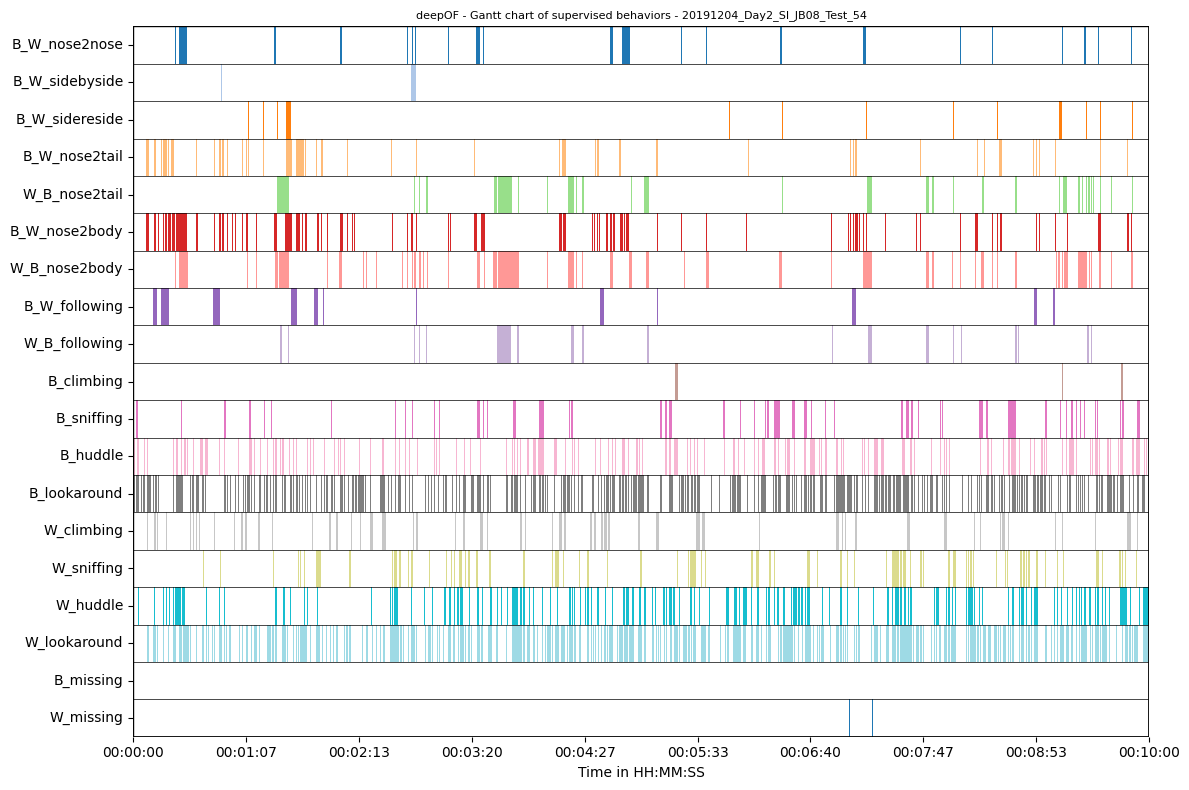

In [22]:
plt.figure(figsize=(12, 8))

deepof.visuals.plot_gantt(
    my_deepof_project,
    "20191204_Day2_SI_JB08_Test_54",
    supervised_annotations=supervised_annotation,   
)

plt.show()

Of course, plotting only a fraction of the samples that your data actually contains will lead to a reduced resolution of the plot and can be misleading. Let's say one behavior only occurs every 100 frames but pretty regularly. If the plot gets downsamples by a factor of 100 it may happen that the included samples are mostly the ones where this specific behavior occurs. Respectively in the downsampled plot it will seem as this behavior is way more frequent than it actually is. 


Info! The selected range for plotting exceeds the maximum number of 500 samples allowed for plotting!
To plot the selected full range the plot will be downsampled accordingy by a factor of approx. 29.
To avoid this, you can increase the input parameter "samples_max", but this also increases computation time.



Warning! Since the provided time bins contain gaps, the time range below may be incorrectly displayed!


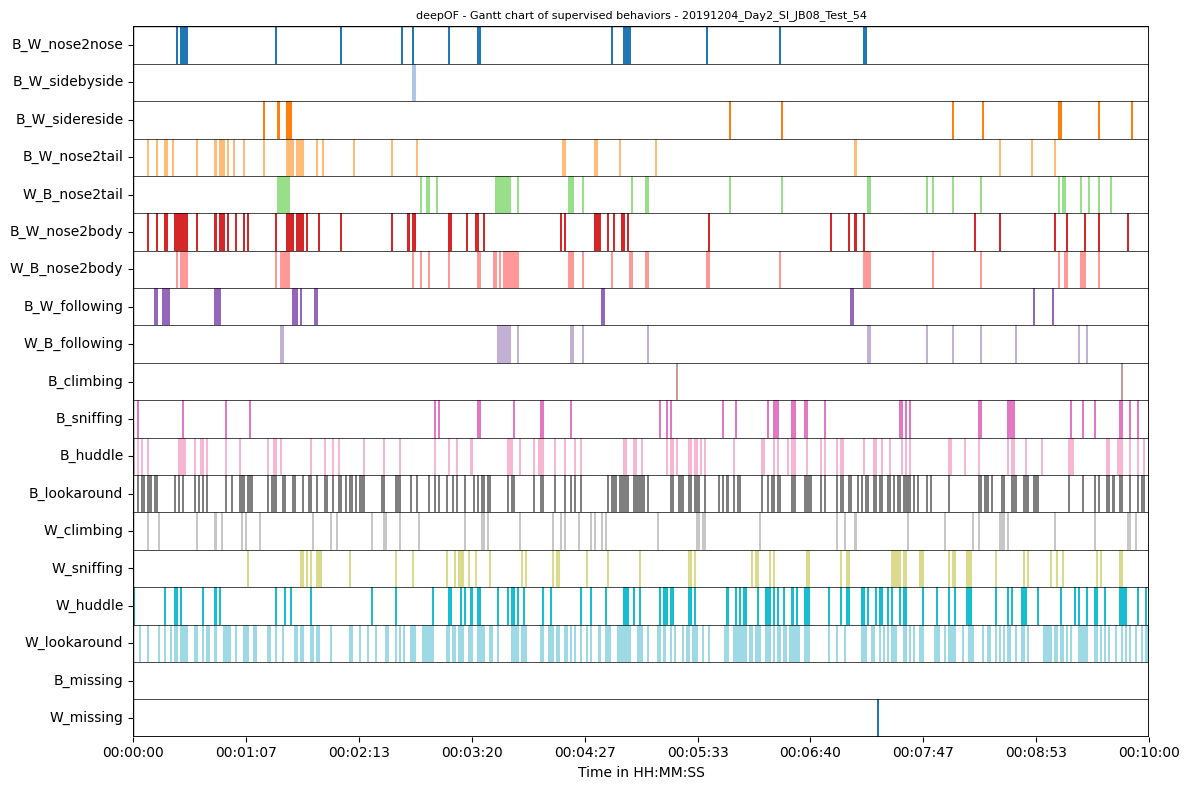

In [23]:
plt.figure(figsize=(12, 8))

deepof.visuals.plot_gantt(
    my_deepof_project,
    "20191204_Day2_SI_JB08_Test_54",
    supervised_annotations=supervised_annotation,
    samples_max=500,   
)

plt.show()

Respectively for large datasets it becomes especially relevant to also look at sections of your plots. You can do this with the bin_index and bin_size inputs providing either bin numbers and sizes (with the size being given in seconds) or start times and durations. Let us plot only the second minute of the gantt plot with both notations.

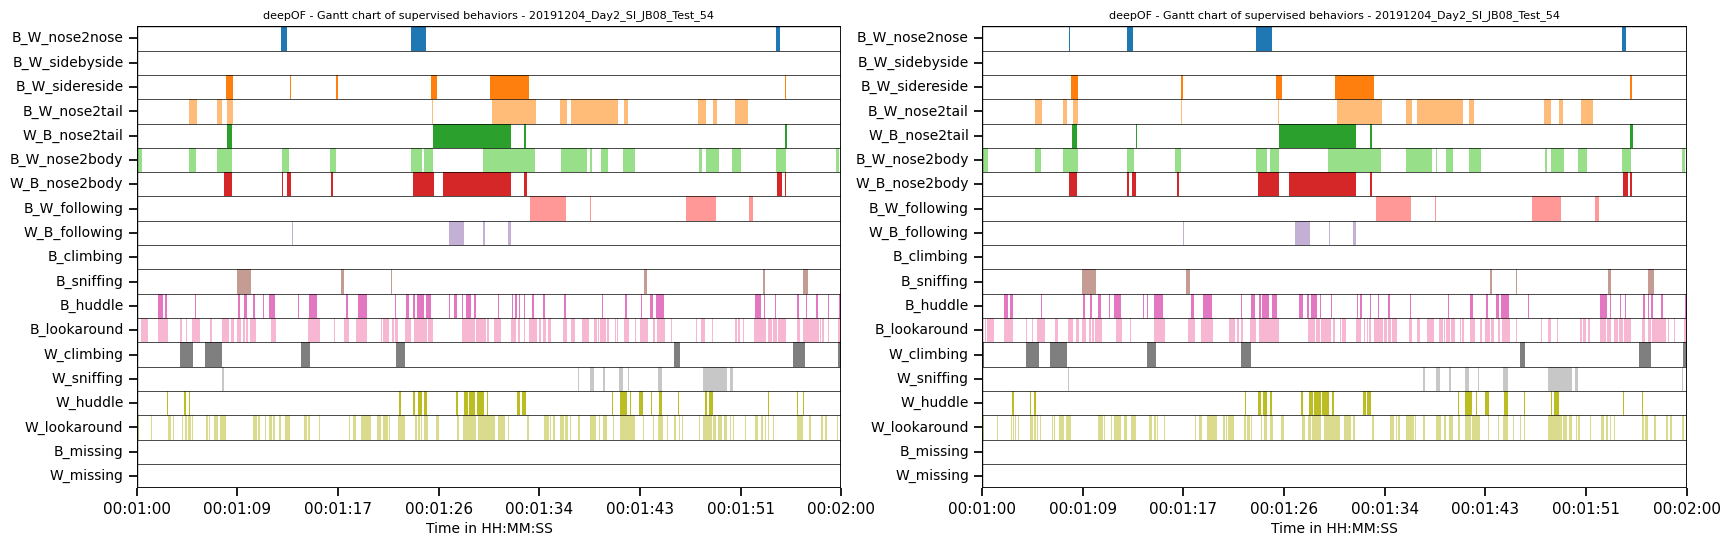

In [24]:
sns.set_context("notebook")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

deepof.visuals.plot_gantt(
    my_deepof_project,
    "20191204_Day2_SI_JB08_Test_54",
    supervised_annotations=supervised_annotation,
    bin_index=1,
    bin_size=60,
    ax=ax1  
)

deepof.visuals.plot_gantt(
    my_deepof_project,
    "20191204_Day2_SI_JB08_Test_54",
    supervised_annotations=supervised_annotation,
    bin_index="0:01:00",
    bin_size="0:01:00",
    ax=ax2  
)

plt.show()

We also can compare one specific behavior accross all of our experiments. This becomes especially relevant when working with large datasets and having mice missing for longer periods of times (because tehy are sleeping in their shelters). You can do this by simply calling the Gantt plot with a behavior instead of the key for a specifiv experiment:

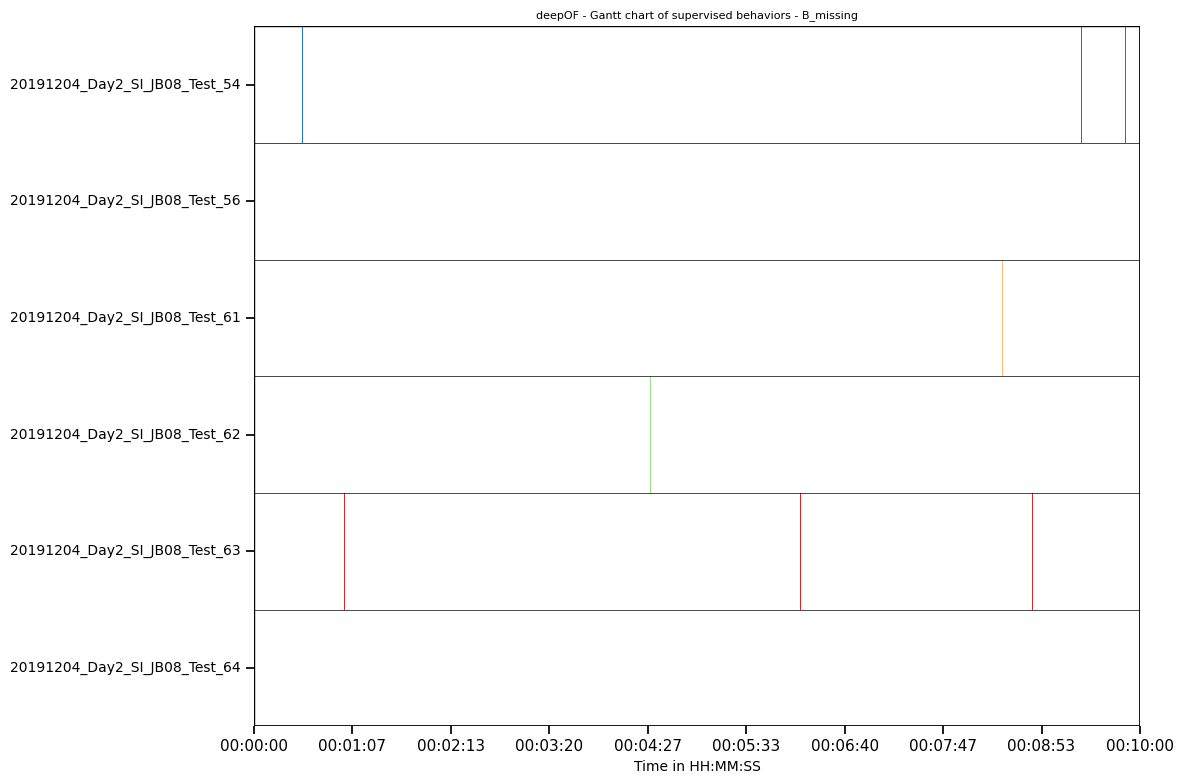

In [25]:
plt.figure(figsize=(12, 8))

deepof.visuals.plot_gantt(
    my_deepof_project,
    "B_missing",
    supervised_annotations=supervised_annotation,
)

plt.show()

Since this experiment is only 10 minutes long there where no times where the mice were sleeping, but I think you get the point.

Let's say we now identified a good section where all mice are active. In this case it does not really matter but let's take the second minute as an example. If we want to train a model to see if there are any differences, we can do as we learned in the unsupervised pipeline tutorial. The only difference is that we only extract graph data from a section of our data in this case, using the bin_index and bin_size arguments again. 

In [26]:
# This code will generate a dataset using graph representations, as well a some auxiliary objects
graph_preprocessed_coords, shapes, adj_matrix, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
    animal_id="B", # Comment out for multi-animal embeddings
    center="Center",
    align="Spine_1",
    window_size=25,
    window_step=1,
    test_videos=1,
    preprocess=True,
    scale="standard",
    bin_index="0:01:00",
    bin_size="0:01:00",
)

Reshaping     : 100%|██████████| 2/2 [00:00<00:00,  9.45table/s]


**NOTE**: If you do not select custom bins for very large datasets, only a down sampled version from all of your data is used dependent on the working memory you have available. This is often undesirable as it will result in gaps between frames and the inclusion of suboptimal intervalls, such as sleeping periods. 

Now we can train our model and extract the embeddings just as in the unsupervised pipeline tutorial

In [27]:
trained_model = my_deepof_project.deep_unsupervised_embedding(
    preprocessed_object=graph_preprocessed_coords, # Change to preprocessed_coords to use non-graph embeddings
    adjacency_matrix=adj_matrix,
    embedding_model="VaDE", # Can also be set to 'VQVAE' and 'Contrastive'
    epochs=10,
    encoder_type="recurrent", # Can also be set to 'TCN' and 'transformer'
    n_components=10,
    latent_dim=6,
    batch_size=1024,
    verbose=True, # Set to True to follow the training loop
    interaction_regularization=0.0,
    pretrained=True, # Set to False to train a new model!
)

In [28]:
# Get embeddings, soft_counts, and breaks per video
embeddings, soft_counts = deepof.model_utils.embedding_per_video(
    coordinates=my_deepof_project,
    to_preprocess=to_preprocess, 
    model=trained_model,
    animal_id="B",
    global_scaler=global_scaler,
)

Computing embeddings: 100%|██████████| 6/6 [01:41<00:00, 16.94s/table]


And whilst none of the generated tables are stored in memory...

In [29]:
embeddings["20191204_Day2_SI_JB08_Test_54"]

'./tutorial_files\\sample_project\\Tables\\20191204_Day2_SI_JB08_Test_54\\20191204_Day2_SI_JB08_Test_54_unsup_embed.npy'

... we can plot with them just as usual

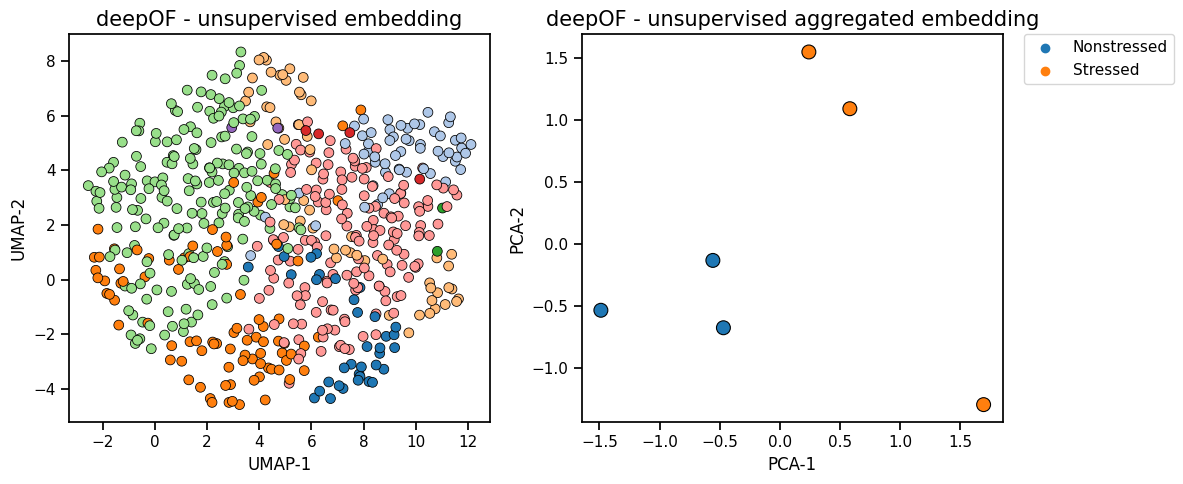

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments=None,
    samples=100,
    colour_by="cluster",
    ax=ax1,
    save=False,  # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings,
    soft_counts,
    aggregate_experiments="time on cluster",  # Can also be set to 'mean' and 'median'
    exp_condition="CSDS",
    show_aggregated_density=False,
    ax=ax2,
    save=False,  # Set to True, or give a custom name, to save the plot,
)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.tight_layout()
plt.show()

But as you should know, if we train any model on a set of only 6 1-minute long data sets, the results are not meaningful as we just get significant overfitting.